In [ ]:
INPUT Shape= 180*180

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [5]:
train_df = pd.read_csv('/kaggle/input/urpc-tf/train/_annotations.csv')
test_df = pd.read_csv('/kaggle/input/urpc-tf/test/_annotations.csv')
valid_df = pd.read_csv('/kaggle/input/urpc-tf/valid/_annotations.csv')

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/urpc-tf/train',
    x_col='filename',
    y_col='class',
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 28427 validated image filenames belonging to 4 classes.


In [8]:
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/urpc-tf/valid',
    x_col='filename',
    y_col='class',
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 5676 validated image filenames belonging to 4 classes.


In [9]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/urpc-tf/test',
    x_col='filename',
    y_col='class',
    target_size=(180, 180),
    batch_size=64,
    class_mode='categorical'
)

Found 1994 validated image filenames belonging to 4 classes.


In [10]:
# Loading vgg16 model Also Fine-Tuning the Fully-connected Layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(460, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu')(x)
x = Dense(188, activation='relu')(x)
 
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
custom_learning_rate = 0.0003102
optimizer = Adam(learning_rate=custom_learning_rate)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │     5,888,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           75

 Total params: 20,640,436 (78.74 MB)

 Trainable params: 5,925,748 (22.60 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Training Of Model

history_vgg16= model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718738943.777561     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718738943.802060     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/444 ━━━━━━━━━━━━━━━━━━━━ 1:53 374ms/step - accuracy: 0.5198 - loss: 2.0930

W0000 00:00:1718738995.519437     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5720 - loss: 1.4551

W0000 00:00:1718739061.277273     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 182s 310ms/step - accuracy: 0.5720 - loss: 1.4542 - val_accuracy: 0.6422 - val_loss: 0.8922
Epoch 2/20
  1/444 ━━━━━━━━━━━━━━━━━━━━ 1:13 165ms/step - accuracy: 0.7031 - loss: 0.8662

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


444/444 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.7031 - loss: 0.8662 - val_accuracy: 0.5909 - val_loss: 1.0168
Epoch 3/20


W0000 00:00:1718739109.525823     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 106s 235ms/step - accuracy: 0.6326 - loss: 0.8801 - val_accuracy: 0.6404 - val_loss: 0.8923
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.6875 - loss: 0.9422 - val_accuracy: 0.7500 - val_loss: 0.7320
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 105s 233ms/step - accuracy: 0.6479 - loss: 0.8257 - val_accuracy: 0.6415 - val_loss: 0.8575
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.7188 - loss: 0.7803 - val_accuracy: 0.6818 - val_loss: 0.8434
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 110s 244ms/step - accuracy: 0.6602 - loss: 0.7999 - val_accuracy: 0.6475 - val_loss: 0.8561
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.6719 - loss: 0.7923 - val_accuracy: 0.8182 - val_loss: 0.6404
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 109s 242ms/step - accuracy: 0.6612 - loss: 0.7808 - val_accuracy: 0.6454 - val_loss: 0.8691
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.6875 - loss: 0.7629 - va

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6858 - loss: 0.8260
Test loss: 0.8546978831291199
Test accuracy: 0.6743951439857483


In [15]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

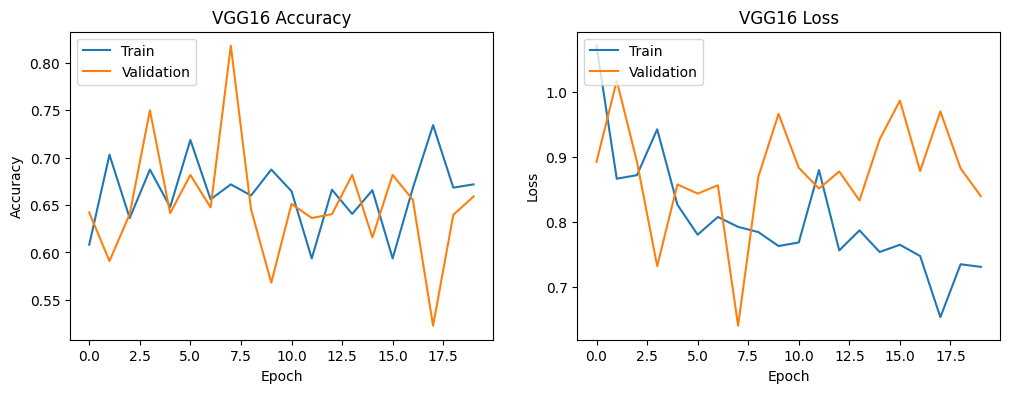

In [16]:
# Plot history for VGG16
plot_history(history_vgg16,'VGG16')

In [18]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step
              precision    recall  f1-score   support

     echinus       0.42      0.63      0.50       835
 holothurian       0.14      0.09      0.11       275
     scallop       0.35      0.28      0.31       635
    starfish       0.15      0.05      0.08       249

    accuracy                           0.37      1994
   macro avg       0.27      0.26      0.25      1994
weighted avg       0.33      0.37      0.33      1994



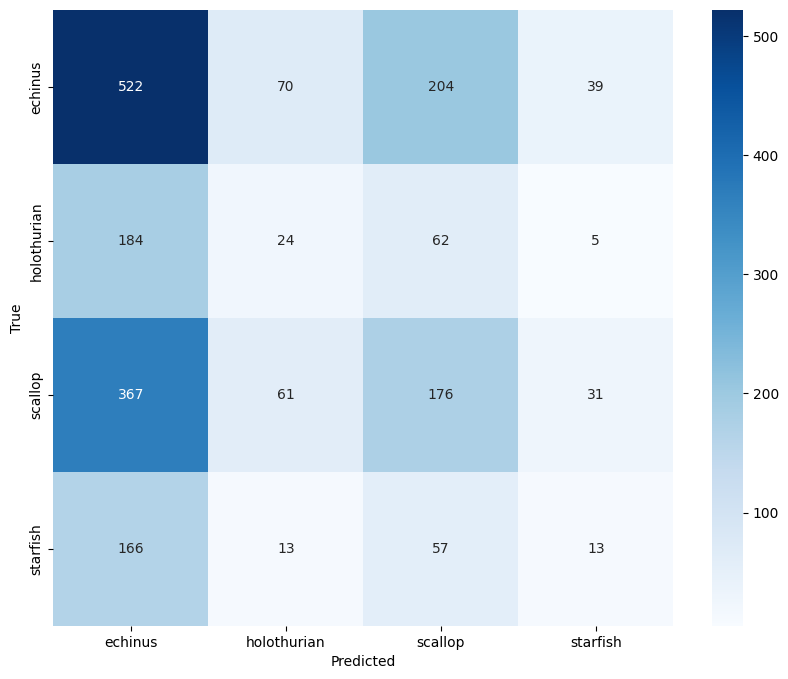

In [19]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [21]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.32689544063241127
Recall: 0.3686058174523571
F1 Score: 0.33421932379481833


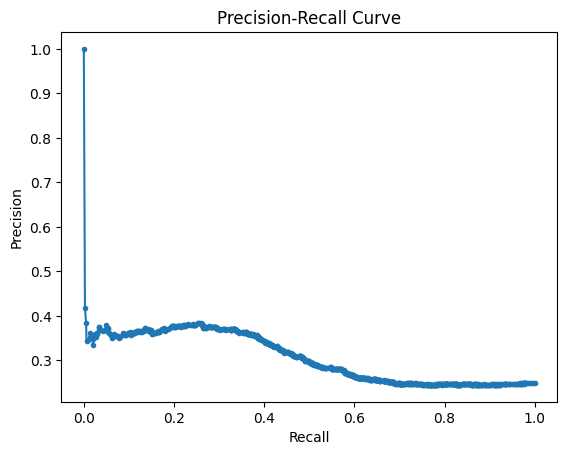

In [22]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [23]:
# Save the VGG16 model
model.save('Vgg16_URPC19(67.43%).h5')